In [ ]:
!pip install tensorflow==2.12.0

In [ ]:
!gcloud auth application-default login --scopes=https://www.googleapis.com/auth/cloud-platform


You are running on a Google Compute Engine virtual machine.
The service credentials associated with this virtual machine
will automatically be used by Application Default
Credentials, so it is not necessary to use this command.

If you decide to proceed anyway, your user credentials may be visible
to others with access to this virtual machine. Are you sure you want
to authenticate with your personal account?

Do you want to continue (Y/n)?  y

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&state=2cdmFB0PLvErmtRIKAZ11O5qTyPD53&prompt=consent&access_type=offline&code_challenge=gRD2HwGTGYq9TjD1f5prrgBD8qye6fTLnQkaLz53Wv0&code_challenge_method=S256

Enter authorization code: 4/0AfJohXlAR0G-uA0RFT2Hemonza0

# Imports

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout,Dense, Input, Masking, GlobalAveragePooling1D, Embedding, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Huber


In [2]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)


Tensorflow version 2.12.0
Running on TPU  ['10.57.87.66:8470']


# Parsing and Filtering Feature Set

In [184]:
full_feature_list = sorted(['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_50', 'MACD_12_26_9', 'RSI_50', 'SMA_50', 'average_sentiment_score'])

features_to_remove = []

feature_list = [feature for feature in full_feature_list if feature not in features_to_remove]

In [185]:
def parse_tfrecord_fn(example_proto, feature_list):
    # Define the feature description
    feature_description = {}
    num_days = 20

    for day in range(num_days):
        for feature in feature_list:
            feature_key = f"{feature}_{day}"
            feature_description[feature_key] = tf.io.FixedLenFeature([], tf.float32)

    feature_description['label'] = tf.io.FixedLenFeature([], tf.float32)

    # Parse the input `tf.train.Example` proto
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # Extract and reshape features
    features = [parsed_features[f"{feature}_{day}"] for day in range(num_days) for feature in feature_list]
    features_tensor = tf.reshape(tf.stack(features), (num_days, len(feature_list)))


    # Extract label
    label = parsed_features['label']

    return features_tensor, label


batch_size = 128  # You can adjust this size


In [171]:
def test_tfrecord_parsing(tfrecord_path, timestep_to_print=0):
    # Load one example from the TFRecord
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    for raw_record in raw_dataset.take(1):
        features_tensor, label = parse_tfrecord_fn(raw_record, feature_list)

        # Print the specified timestep and its features
        print(f"Label: {label.numpy()}")
        print(f"Features at timestep {timestep_to_print}:")
        for index, feature in enumerate(feature_list):
            print(f"  Feature {feature}: {features_tensor[timestep_to_print, index].numpy()}")

# Example usage
tfrecord_path = 'gs://trendformer/Datasets/10_features/with_names/training_data.tfrecord'
test_tfrecord_parsing(tfrecord_path, timestep_to_print=2)

Exception ignored in: <function Executor.__del__ at 0x7f239c13d2d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Label: -0.27935561537742615
Features at timestep 2:
  Feature EMA_50: -0.4219035804271698
  Feature High: -0.3794245421886444
  Feature Low: -0.37914973497390747
  Feature MACD_12_26_9: 0.17683055996894836
  Feature RSI_50: 1.648718237876892
  Feature SMA_50: -0.4200937747955322
  Feature Volume: -0.5366491079330444


In [176]:
def print_example():
  for features_tensor, label in train_dataset.take(1):
      # Convert the tensor to numpy array
      features_array = features_tensor.numpy()
      label_value = label.numpy()

      # Print the features for each day
      for day in range(num_days):
          print(f"Day {day + 1} features:")
          for feature_index, feature_name in enumerate(feature_list):
              # The feature index needs to account for the day offset
              actual_feature_index = day * len(feature_list) + feature_index
              feature_value = features_array[day, feature_index]
              print(f"{feature_name}: {feature_value}")
      print(f"Label: {label_value}")

# Loading Training Examples

In [186]:
train_tfrecord_path = 'gs://trendformer/Datasets/10_features/with_names/training_data.tfrecord'
val_tfrecord_path = 'gs://trendformer/Datasets/10_features/with_names/validation_data.tfrecord'
train_dataset = tf.data.TFRecordDataset(train_tfrecord_path).map(lambda example: parse_tfrecord_fn(example, feature_list))
val_dataset = tf.data.TFRecordDataset(val_tfrecord_path).map(lambda example: parse_tfrecord_fn(example, feature_list))

In [ ]:
print_example()

In [188]:
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Model Definition

In [193]:
# Define the Transformer's parameters
d_model = 512  # Embedding dimension

num_heads = 8  # Number of attention heads
dff = 2048  # Dimension of the feed-forward network
num_layers = 6  # Number of encoder and decoder layers
dropout_rate = 0.3  # Dropout rate

# Constant learning rate
constant_learning_rate = 1e-6

# [32, 20, 10]
seq_length = 20  # Length of your input sequences
feature_size = len(feature_list)  # Number of features in your dataset

with tpu_strategy.scope():
  # Define custom Directional Accuracy metric for Keras
  def directional_accuracy(y_true, y_pred):
      # Assuming the shape of y_true and y_pred is (batch_size, 1)
      sign_true = K.sign(y_true[1:] - y_true[:-1])
      sign_pred = K.sign(y_pred[1:] - y_pred[:-1])
      return K.mean(K.equal(sign_true, sign_pred), axis=-1)

  # Define custom R2 score metric for Keras
  def r2_score(y_true, y_pred):
      SS_res =  K.sum(K.square(y_true - y_pred))
      SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
      return (1 - SS_res/(SS_tot + K.epsilon()))

  def positional_encoding(seq_length, num_features):
      """
      Create positional encodings for the input.

      Parameters:
      seq_length (int): The length of the sequence.
      num_features (int): The number of features being encoded.

      Returns:
      np.ndarray: A seq_length x num_features array of positional encodings.
      """

      # Initialize the positional encoding matrix
      position = np.arange(seq_length)[:, np.newaxis]
      div_term = np.exp(np.arange(0, num_features, 2) * -(np.log(10000.0) / num_features))

      # Compute the positional encodings
      pe = np.zeros((seq_length, num_features))
      pe[:, 0::2] = np.sin(position * div_term)
      pe[:, 1::2] = np.cos(position * div_term)

      return pe

  def transformer_encoder_layer(d_model, num_heads, dff, dropout_rate, name):
      inputs = Input(shape=(None, d_model))
      attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
      attention = Dropout(dropout_rate)(attention)
      attention = LayerNormalization(epsilon=1e-6)(inputs + attention)

      outputs = Dense(dff, activation='relu')(attention)
      outputs = Dense(d_model)(outputs)
      outputs = Dropout(dropout_rate)(outputs)
      outputs = LayerNormalization(epsilon=1e-6)(attention + outputs)

      return Model(inputs=inputs, outputs=outputs, name=name)

  def transformer_decoder_layer(d_model, num_heads, dff, dropout_rate, name):
      inputs = Input(shape=(None, d_model))
      enc_outputs = Input(shape=(None, d_model))

      # Attention layer 1
      attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
      attention1 = Dropout(dropout_rate)(attention1)
      attention1 = LayerNormalization(epsilon=1e-6)(attention1 + inputs)

      # Attention layer 2
      attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(attention1, enc_outputs)
      attention2 = Dropout(dropout_rate)(attention2)
      attention2 = LayerNormalization(epsilon=1e-6)(attention2 + attention1)

      # Feed-forward layer
      outputs = Dense(dff, activation='relu')(attention2)
      outputs = Dense(d_model)(outputs)
      outputs = Dropout(dropout_rate)(outputs)
      outputs = LayerNormalization(epsilon=1e-6)(outputs + attention2)

      return Model(inputs=[inputs, enc_outputs], outputs=outputs, name=name)

  def transformer_model(seq_length, feature_size, d_model, num_heads, dff, num_layers, dropout_rate):
      inputs = Input(shape=(seq_length, feature_size))

      # Extracting the open prices and applying positional encoding
      open_prices = inputs[:, :, 5:6]  # Assuming 0-based indexing, the 11th feature is at index 10
      open_prices_pos_encoding = positional_encoding(seq_length, d_model)
      open_prices += open_prices_pos_encoding

      feature_embeddings = Dense(d_model)(inputs)
      pos_encoding = positional_encoding(seq_length, d_model)
      feature_embeddings += pos_encoding

      x = feature_embeddings
      for i in range(num_layers):
          x = transformer_encoder_layer(d_model, num_heads, dff, dropout_rate, f"encoder_layer_{i+1}")(x)

      encoder_output = x

      # Preparing the decoder inputs by expanding the dimensions of the open prices to match the encoder output
      decoder_output = open_prices
      # Passing the combined inputs through the decoder layers
      for i in range(num_layers):
        decoder_output = transformer_decoder_layer(d_model, num_heads, dff, dropout_rate, f"decoder_layer_{i+1}")([decoder_output, encoder_output])

      decoder_output = Lambda(lambda x: x[:, -1, :])(decoder_output)

      outputs = Dense(1, activation='linear')(decoder_output)
      model = Model(inputs=inputs, outputs=outputs)
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=constant_learning_rate),
                    loss=Huber(delta=1.0),
                    metrics=[directional_accuracy, tf.keras.metrics.MeanSquaredError(name="MSE")])
      return model

  # Create the model
  model = transformer_model(seq_length, feature_size, d_model, num_heads,
                                  dff, num_layers, dropout_rate)

  # Print the model summary to verify the unique naming
  model.summary()

ResourceExhaustedError: ignored

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Assuming 'model' is your defined Transformer model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the image
Image('model_plot.png')

# Fitting Model

In [ ]:
checkpoint_path = "gs://trendformer/Datasets/percent_change_cp.ckpt"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      verbose=1)

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
# Define early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss',  # Metric to monitor
                                        patience=2,         # Number of epochs with no improvement
                                        restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored quantity


In [192]:
epochs = 15

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1
)

Epoch 1/15


ResourceExhaustedError: ignored

# Analysis

Exception ignored in: <function Executor.__del__ at 0x7f239c13d2d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.InvalidArgumentError: indices[8] = 8 is not in [0, 8)
	 [[{{node boolean_mask/GatherV2}}]]
Exception ignored in: <function Executor.__del__ at 0x7f239c13d2d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.InvalidArgumentError: indices[8] = 8 is not i

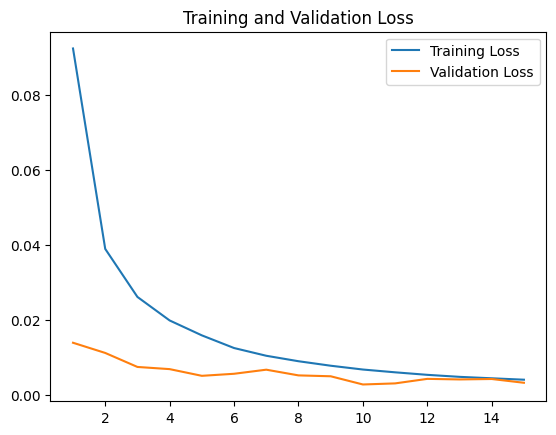

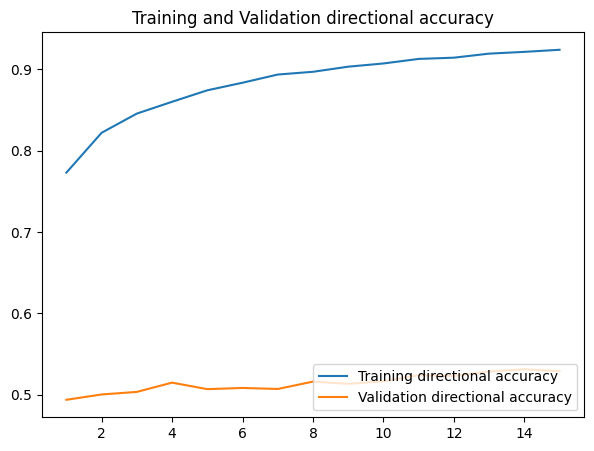

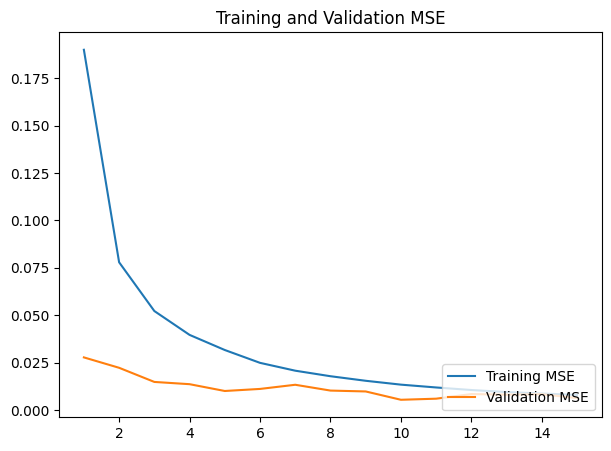

In [180]:
# Assuming 'history' is the result from the model.fit
# Extracting the data from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
da = history.history['directional_accuracy']
val_da = history.history['val_directional_accuracy']
mse = history.history['MSE']
val_mse = history.history['val_MSE']

epochs_range = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.subplot=(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

# Creating a new figure for AUC
plt.figure(figsize=(7, 5))
plt.plot(epochs_range, da, label='Training directional accuracy')
plt.plot(epochs_range, val_da, label='Validation directional accuracy')
plt.title('Training and Validation directional accuracy')
plt.legend(loc='lower right')

plt.figure(figsize=(7, 5))
plt.plot(epochs_range, mse, label='Training MSE')
plt.plot(epochs_range, val_mse, label='Validation MSE')
plt.title('Training and Validation MSE')
plt.legend(loc='lower right')

plt.show()